In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import scipy
from sklearn.model_selection import train_test_split
import re
from collections import defaultdict
from wordcloud import WordCloud, STOPWORDS
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('wordnet')
import warnings
warnings.filterwarnings("ignore")


df = pd.read_csv('df_with_lemmas.csv')
df.drop('Unnamed: 0', axis=1, inplace = True)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
df.price.mean()

2033.7027027027027

In [3]:
df['likes_conversion'] = np.sqrt(df.likes*df.subscribers)

In [4]:
all_words = [word for tokens in df["hashtag"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in df["hashtag"]]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

300345 words total, with a vocabulary size of 73
Max sentence length is 647


In [5]:
all_words = [word for tokens in df["comments_pr"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in df["comments_pr"]]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

905181 words total, with a vocabulary size of 326
Max sentence length is 1307


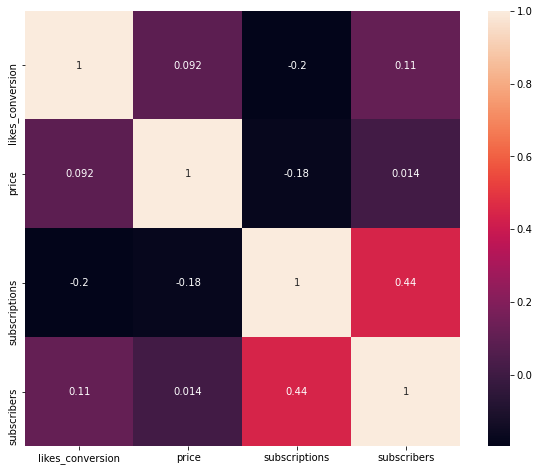

In [6]:
f, ax = plt.subplots(figsize=(10, 8))
corr = df[[
    'likes_conversion',
    'price',
    'subscriptions',
    'subscribers']].corr(method = 'spearman')
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool),
            square=True, ax=ax, annot = True)
plt.show()

In [7]:
list_corpus = df[[
    'price', 
    'hashtag',
    'comments_pr',
    'desc_pr',
    'subscriptions',
    'subscribers']]
list_labels = df["likes_conversion"]

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, random_state=40)

print("Training set: %d samples" % len(X_train))
print("Test set: %d samples" % len(X_test))

Training set: 1480 samples
Test set: 370 samples


In [8]:
bow = dict()
#HASHTAG

count_vectorizer = CountVectorizer(analyzer='word', token_pattern=r'\w+', max_features = 100)
tfidf_transformer = TfidfTransformer()
count_vectorizer.fit(X_train['hashtag'])

train_cv= count_vectorizer.transform(X_train['hashtag'])
X_train_tfidf = tfidf_transformer.fit_transform(train_cv)

test_cv= count_vectorizer.transform(X_test['hashtag'])
X_test_tfidf = tfidf_transformer.fit_transform(test_cv)

#COMMENTS
count_vectorizer = CountVectorizer(analyzer='word', token_pattern=r'\w+', max_features = 50)
tfidf_transformer = TfidfTransformer()
count_vectorizer.fit(X_train['comments_pr'])

train_cv_comm= count_vectorizer.transform(X_train['comments_pr'])
X_train_tfidf_comm = tfidf_transformer.fit_transform(train_cv_comm)

test_cv_comm= count_vectorizer.transform(X_test['comments_pr'])
X_test_tfidf_comm = tfidf_transformer.fit_transform(test_cv_comm)

#DESCS
count_vectorizer = CountVectorizer(analyzer='word', token_pattern=r'\w+', max_features = 20)
tfidf_transformer = TfidfTransformer()

count_vectorizer.fit(X_train['desc_pr'])

train_cv_descs= count_vectorizer.transform(X_train['desc_pr'])
X_train_tfidf_descs = tfidf_transformer.fit_transform(train_cv_descs)

test_cv_descs= count_vectorizer.transform(X_test['desc_pr'])
X_test_tfidf_descs = tfidf_transformer.fit_transform(test_cv_descs)

#PRICES
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
price_train = ss.fit_transform(np.array(X_train['price']).reshape(-1, 1))
price_test = ss.fit_transform(np.array(X_test['price']).reshape(-1, 1))
#SUBSCRIPTIONS
suscriptions_train = ss.fit_transform(np.array(X_train['subscriptions']).reshape(-1, 1))
suscriptions_test = ss.fit_transform(np.array(X_test['subscriptions']).reshape(-1, 1))

#SUBSCRIBERS
subscribers_train = ss.fit_transform(np.array(X_train['subscribers']).reshape(-1, 1))
subscribers_test = ss.fit_transform(np.array(X_test['subscribers']).reshape(-1, 1))


In [9]:
X_stack_train = scipy.sparse.hstack((X_train_tfidf,
                                     np.array(price_train),
                                     np.array(suscriptions_train), 
                                     X_train_tfidf_comm,
                                    X_train_tfidf_descs))
X_stack_test = scipy.sparse.hstack((X_test_tfidf,
                                    np.array(price_test), 
                                    np.array(suscriptions_test),
                                    X_test_tfidf_comm,
                                   X_test_tfidf_descs))

bow["train"] = (X_stack_train, y_train)
bow["test"]  = (X_stack_test, y_test)

In [10]:
def get_metrics(y_test, y_predicted):  
    r2 = r2_score(y_test, y_predicted)     
    rmse = np.sqrt(mean_squared_error(y_test, y_predicted))
    mae = mean_absolute_error(y_test, y_predicted)
    print('R2: ', r2)
    print('Root Mean Squared Error: ', rmse)
    print('Mean Absolute Error: ', mae)
    #return r2, mse, mae

In [11]:
embedding = bow 
lr = LinearRegression()

In [12]:
lr.fit(embedding["train"][0], embedding["train"][1])

LinearRegression()

In [13]:
print('Train')
y_predict = lr.predict(embedding["train"][0])
get_metrics(embedding["train"][1], y_predict)

Train
R2:  0.683426615458755
Root Mean Squared Error:  1077.7242427013373
Mean Absolute Error:  623.6367790381523


In [14]:
print('Test')
y_predict = lr.predict(embedding["test"][0])
get_metrics(embedding["test"][1], y_predict)

Test
R2:  0.589047039412692
Root Mean Squared Error:  1192.6378126153734
Mean Absolute Error:  716.3705947844658


In [15]:
mlp = MLPRegressor(
    hidden_layer_sizes=1000,
    activation='tanh',
    solver = 'adam',
    learning_rate='adaptive',
    momentum=0.99,
    nesterovs_momentum=True,
verbose=True,
learning_rate_init=0.1,
tol=0.000000001,
random_state=2021)
mlp.fit(embedding["train"][0], embedding["train"][1])

Iteration 1, loss = 2646695.29366887
Iteration 2, loss = 1996104.91735939
Iteration 3, loss = 1810236.50480160
Iteration 4, loss = 1591247.45895005
Iteration 5, loss = 1404005.52910735
Iteration 6, loss = 1302805.19969216
Iteration 7, loss = 1226861.20318450
Iteration 8, loss = 1150508.13147066
Iteration 9, loss = 1086944.82774299
Iteration 10, loss = 1027534.92966635
Iteration 11, loss = 978298.98253423
Iteration 12, loss = 932151.05927495
Iteration 13, loss = 877616.99010909
Iteration 14, loss = 838547.26572833
Iteration 15, loss = 809185.06244173
Iteration 16, loss = 765888.17934903
Iteration 17, loss = 722044.61599221
Iteration 18, loss = 703342.26993246
Iteration 19, loss = 678079.57764630
Iteration 20, loss = 632213.42263078
Iteration 21, loss = 608283.31123272
Iteration 22, loss = 588780.49424309
Iteration 23, loss = 571703.23657943
Iteration 24, loss = 559524.28835503
Iteration 25, loss = 535397.04996749
Iteration 26, loss = 521065.10082206
Iteration 27, loss = 503237.83788444


MLPRegressor(activation='tanh', hidden_layer_sizes=1000,
             learning_rate='adaptive', learning_rate_init=0.1, momentum=0.99,
             random_state=2021, tol=1e-09, verbose=True)

In [16]:
print('Train')
y_predict = mlp.predict(embedding["train"][0])
get_metrics(embedding["train"][1], y_predict.astype(int))

Train
R2:  0.9197675764319038
Root Mean Squared Error:  542.5570461250629
Mean Absolute Error:  222.64203667705408


In [17]:
print('Test')
y_predict = mlp.predict(embedding["test"][0])
get_metrics(embedding["test"][1], y_predict.astype(int))

Test
R2:  0.6637951240712909
Root Mean Squared Error:  1078.7343834553888
Mean Absolute Error:  659.4083456065663


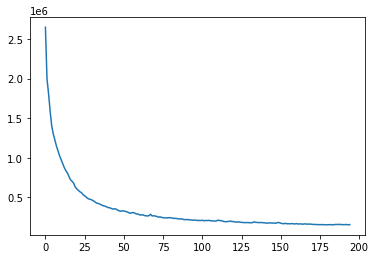

In [18]:
plt.plot(mlp.loss_curve_)
plt.show()

In [19]:
rfr = RandomForestRegressor(n_estimators=100, verbose=3, random_state=2021)
rfr.fit(embedding["train"][0], embedding["train"][1])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   11.3s finished


RandomForestRegressor(random_state=2021, verbose=3)

In [20]:
print('Train')
y_predict = rfr.predict(embedding["train"][0])
get_metrics(embedding["train"][1], y_predict.astype(int))

Train
R2:  0.9380803533894477
Root Mean Squared Error:  476.63363574165044
Mean Absolute Error:  228.53694987474017


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [21]:
print('Test')
y_predict = rfr.predict(embedding["test"][0])
get_metrics(embedding["test"][1], y_predict.astype(int))

Test
R2:  0.2245727251757753
Root Mean Squared Error:  1638.2608547238679
Mean Absolute Error:  786.279848591764


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [23]:
#ngram function
def ngram_extractor(text, n_gram):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

# Function to generate a dataframe with n_gram and top max_row frequencies
def generate_ngrams(df, n_gram, max_row):
    temp_dict = defaultdict(int)
    for question in df:
        for word in ngram_extractor(question, n_gram):
            temp_dict[word] += 1
    temp_df = pd.DataFrame(sorted(temp_dict.items(), key=lambda x: x[1])[::-1]).head(max_row)
    temp_df.columns = ["word", "wordcount"]
    return temp_df

#Function to construct side by side comparison plots
def comparison_plot(df_1,df_2,col_1,col_2, space):
    fig, ax = plt.subplots(1, 2, figsize=(20,10))
    
    sns.barplot(x=col_2, y=col_1, data=df_1, ax=ax[0], color="royalblue")
    sns.barplot(x=col_2, y=col_1, data=df_2, ax=ax[1], color="royalblue")

    ax[0].set_xlabel('Word count', size=14)
    ax[0].set_ylabel('Words', size=14)
    ax[0].set_title('Top 20 Bi-grams in Descriptions', size=18)

    ax[1].set_xlabel('Word count', size=14)
    ax[1].set_ylabel('Words', size=14)
    ax[1].set_title('Top 20 Tri-grams in Descriptions', size=18)

    fig.subplots_adjust(wspace=space)
    
    plt.show()


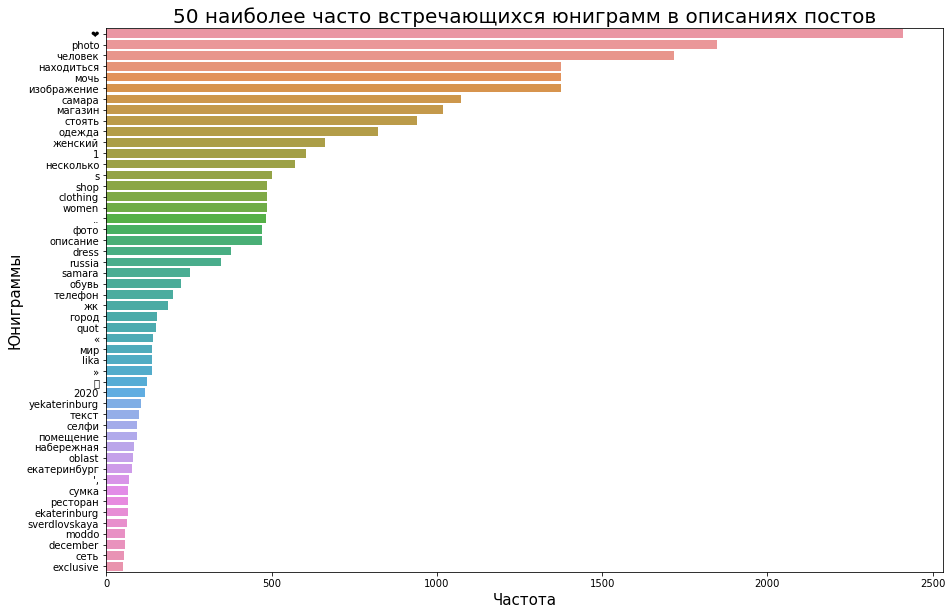

In [30]:
#Generate unigram for data analyst
unigram = generate_ngrams(df['desc_pr'], 1, 50)
#generate barplot for unigram
plt.figure(figsize=(15,10))
sns.barplot(unigram["wordcount"],unigram["word"])
plt.xlabel("Частота", fontsize=15)
plt.ylabel("Юниграммы", fontsize=15)
plt.title("50 наиболее часто встречающихся юниграмм в описаниях постов", fontsize=20)
plt.show()

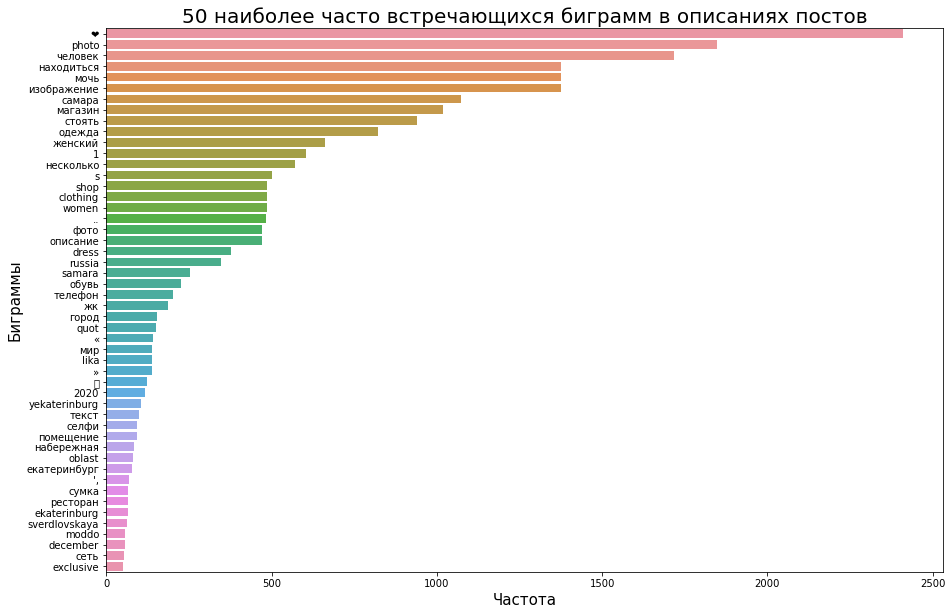

In [31]:
#Generate unigram for data analyst
bigram = generate_ngrams(df['desc_pr'], 2, 50)
#generate barplot for unigram
plt.figure(figsize=(15,10))
sns.barplot(unigram["wordcount"],unigram["word"])
plt.xlabel("Частота", fontsize=15)
plt.ylabel("Биграммы", fontsize=15)
plt.title("50 наиболее часто встречающихся биграмм в описаниях постов", fontsize=20)
plt.show()

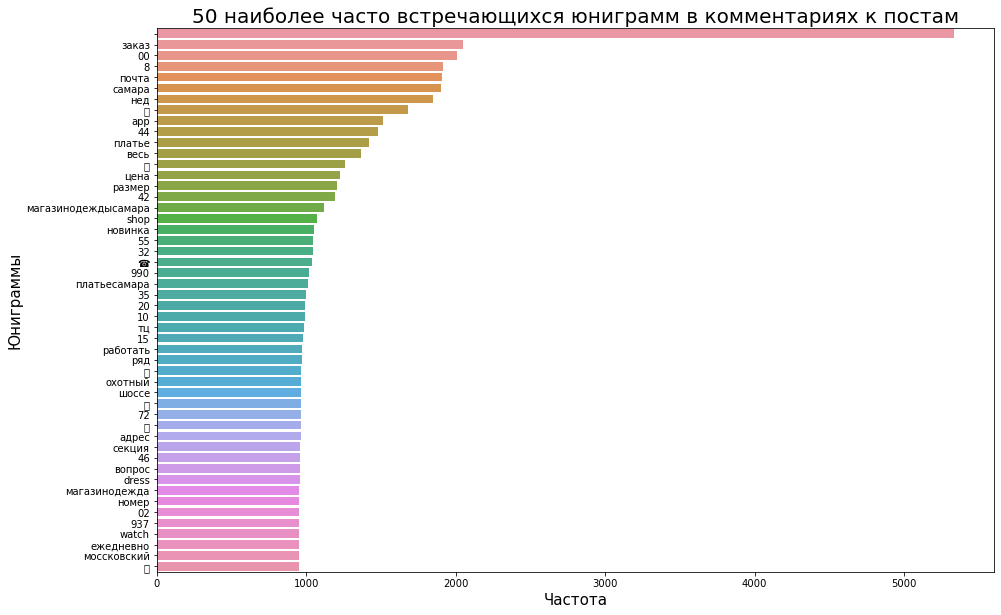

In [32]:
#Generate unigram for data analyst
unigram = generate_ngrams(df['comments_pr'], 1, 50)
#generate barplot for unigram
plt.figure(figsize=(15,10))
sns.barplot(unigram["wordcount"],unigram["word"])
plt.xlabel("Частота", fontsize=15)
plt.ylabel("Юниграммы", fontsize=15)
plt.title("50 наиболее часто встречающихся юниграмм в комментариях к постам", fontsize=20)
plt.show()

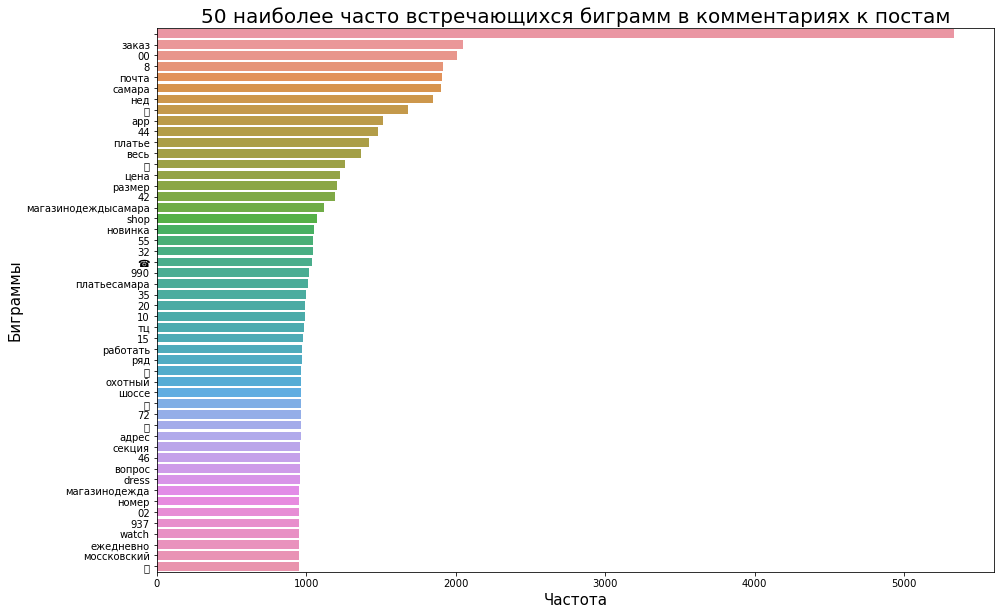

In [33]:
#Generate unigram for data analyst
bigram = generate_ngrams(df['comments_pr'], 2, 50)
#generate barplot for unigram
plt.figure(figsize=(15,10))
sns.barplot(unigram["wordcount"],unigram["word"])
plt.xlabel("Частота", fontsize=15)
plt.ylabel("Биграммы", fontsize=15)
plt.title("50 наиболее часто встречающихся биграмм в комментариях к постам", fontsize=20)
plt.show()